# Plotting sea ice 

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.path as mpath
import numpy as np
%matplotlib inline

#import glob

#import xesmf
#import os
#import pandas as pd
#import calendar
#from tqdm import tqdm_notebook
from datetime import timedelta

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38309,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:41789,Total threads: 4
Dashboard: /proxy/45805/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:45407,


In [3]:
session_CM2  = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [5]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
fig_path     = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [40]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})
month_label = ['J','F','M','A','M','J','J','A','S','O','N','D']

### Grid information

In [16]:
area_t025 = cc.querying.getvar(expt_OM2_025, 'area_t', session_OM2, n=1)
area_t1   = cc.querying.getvar(expt_OM2_1, 'area_t', session_OM2, n=1)

In [17]:
geolon_t025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [18]:
geolon_t1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolon_t
geolat_t1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolat_t

### Observations

Sea ice concentration is previously calculated in `Calc_NSIDC_sic_onto_OM2_grid.ipynb`.

In [24]:
NH_sic_obs = xr.open_dataarray('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_NH_grid_OM2_025.nc')
SH_sic_obs = xr.open_dataarray('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_SH_grid_OM2_025.nc')

Sea ice concentration in peak season

In [25]:
# NH: March
NH_sic_obs_Mar = NH_sic_obs[({"time": NH_sic_obs.time.dt.month == 3})]
# SH: Sep
SH_sic_obs_Sep = SH_sic_obs[({"time": SH_sic_obs.time.dt.month == 9})]

Monthly sic climatology all years

In [26]:
NH_sic_obs_clim = NH_sic_obs.groupby('time.month').mean('time',skipna=True).sel(yt_ocean=slice(45, 90))
SH_sic_obs_clim = SH_sic_obs.groupby('time.month').mean('time',skipna=True).sel(yt_ocean=slice(-90, -45)) 

Monthly climatology of sea ice area, in km2

In [35]:
NH_sia_obs_clim = (NH_sic_obs_clim * area_t025.sel(yt_ocean=slice(45, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
SH_sia_obs_clim = (SH_sic_obs_clim * area_t025.sel(yt_ocean=slice(-90, -45))).sum('xt_ocean').sum('yt_ocean') * 1e-6

Plot

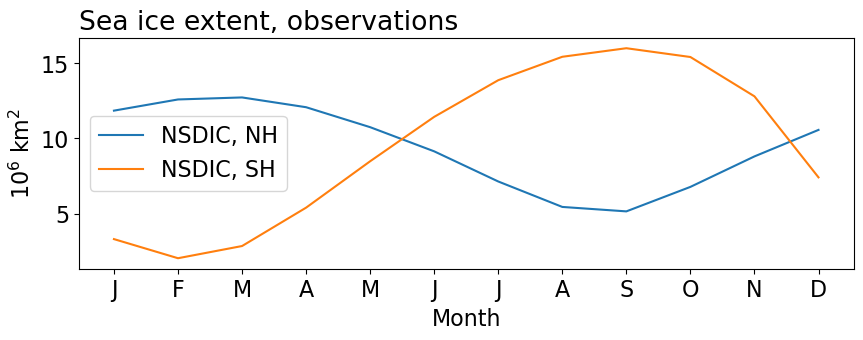

In [45]:
fig = plt.figure(figsize=(10,3))

(NH_sia_obs_clim*1e-6).plot(label='NSDIC, NH')
(SH_sia_obs_clim*1e-6).plot(label='NSDIC, SH')
plt.legend()
plt.title('Sea ice extent, observations', loc='left')
plt.xlabel('Month')
plt.ylabel('10$^{6}$ km$^{2}$')
plt.xticks(ticks=np.arange(1,13,1), labels=month_label);

### Model sea ice

CM2-025

In [ ]:
aice_CM2_025_NH_clim = xr.open_dataarray(path_to_data + 'aice_CM2_025_NH_clim_400_499.nc')
aice_CM2_025_SH_clim = xr.open_dataarray(path_to_data + 'aice_CM2_025_SH_clim_400_499.nc')

In [ ]:
area_t = cc.querying.getvar(expt_CM2_025, 'area_t', session_CM2, n=1)

---

In [13]:
%%time
aice_CM2_025 = cc.querying.getvar(expt_CM2_025, 'aice', session_CM2, frequency='1 monthly', start_time='0400-01-01', end_time='0500-01-31')
aice_CM2_025 = aice_CM2_025.sel(time=slice('0400-01-01', '0500-01-31'))
aice_CM2_025 = aice_CM2_025.time.to_pandas() - timedelta(hours = 12) # shift time to make sure it is in the correct month
aice_CM2_025 = aice_CM2_025.sel(time=slice('0400-01-01', '0499-12-31'))
aice_CM2_025.coords['ni'] = area_t['xt_ocean'].values
aice_CM2_025.coords['nj'] = area_t['yt_ocean'].values
aice_CM2_025 = aice_CM2_025.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

CPU times: user 4min 44s, sys: 39.1 s, total: 5min 23s
Wall time: 15min 10s


In [46]:
aice_CM2_025_NH = aice_CM2_025.sel(yt_ocean=slice(45, 90))
aice_CM2_025_SH = aice_CM2_025.sel(yt_ocean=slice(-90, -45))  

In [47]:
aice_CM2_025_SH_clim = aice_CM2_025_SH.groupby('time.month').mean('time', skipna=True)
aice_CM2_025_NH_clim = aice_CM2_025_NH.groupby('time.month').mean('time', skipna=True)

In [ ]:
aice_CM2_025_SH_clim = aice_CM2_025_SH_clim.load()

In [52]:
aice_CM2_025_NH_clim = aice_CM2_025_NH_clim.load()

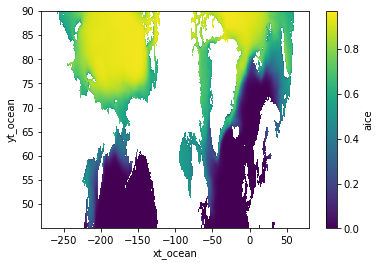

In [54]:
aice_CM2_025_NH_clim.mean('month').plot()

In [55]:
aice_CM2_025_NH_clim.to_netcdf(path_to_data + 'aice_CM2_025_NH_clim_400_499.nc')
aice_CM2_025_SH_clim.to_netcdf(path_to_data + 'aice_CM2_025_SH_clim_400_499.nc')

---

OM2-025 (10 yr for now)

In [116]:
%%time
aice_OM2_025 = cc.querying.getvar(expt_OM2_025, 'aice_m', session_OM2, frequency='1 monthly', start_time='2389-02-01', end_time='2399-01-31')

CPU times: user 24.4 s, sys: 2.86 s, total: 27.3 s
Wall time: 1min 16s


In [117]:
aice_OM2_025 = aice_OM2_025.sel(time=slice('2389-02-01', '2399-01-31'))
aice_OM2_025 = aice_OM2_025.time.to_pandas() - timedelta(hours = 12) # shift time to make sure it is in the correct month
aice_OM2_025 = aice_OM2_025.sel(time=slice('2389-01-01', '2398-12-31'))

AttributeError: 'Series' object has no attribute 'sel'

In [111]:
aice_OM2_025.coords['ni'] = area_t['xt_ocean'].values
aice_OM2_025.coords['nj'] = area_t['yt_ocean'].values
aice_OM2_025 = aice_OM2_025.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

Sea ice area

In [72]:
NH_obs_clim_area = (NH_obs_clim * area_t.sel(yt_ocean=slice(45, 90))).sum('xt_ocean').sum('yt_ocean')
SH_obs_clim_area = (SH_obs_clim * area_t.sel(yt_ocean=slice(45, 90))).sum('xt_ocean').sum('yt_ocean')

In [58]:
area_CM2_025_NH_clim = (aice_CM2_025_NH_clim * area_t.sel(yt_ocean=slice(45, 90))).sum('xt_ocean').sum('yt_ocean')


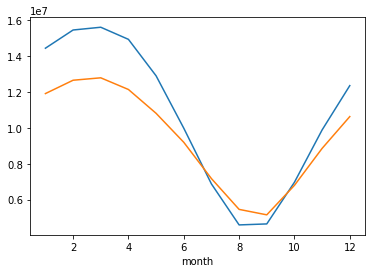

In [73]:
(area_CM2_025_NH_clim*1e-6).plot()
(NH_obs_clim_area*1e-6).plot()

Concentration maps

In [103]:
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [105]:
aice_CM2_025_NH_clim = aice_CM2_025_NH_clim.assign_coords({'geolon_t': geolon_t.sel(yt_ocean=slice(45,90)), 'geolat_t': geolat_t.sel(yt_ocean=slice(45,90))})
NH_obs_clim = NH_obs_clim.assign_coords({'geolon_t': geolon_t.sel(yt_ocean=slice(-90,-45)), 'geolat_t': geolat_t.sel(yt_ocean=slice(-90,-45))})

In [87]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

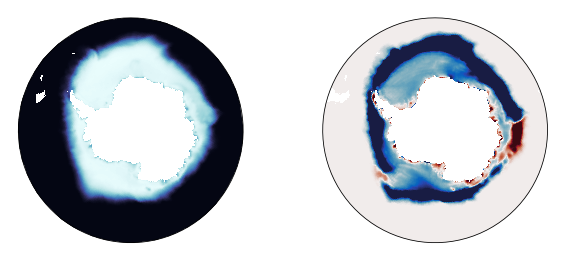

In [98]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.pcolormesh(SH_obs_clim.xt_ocean, SH_obs_clim.yt_ocean, SH_obs_clim[8,...], transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1)

ax = plt.subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.pcolormesh(SH_obs_clim.xt_ocean, SH_obs_clim.yt_ocean, aice_CM2_025_SH_clim[8,...]-SH_obs_clim[8,...], transform=ccrs.PlateCarree(), cmap=cm.cm.balance, vmin=-0.2, vmax=0.2)

### Model ice area

In [ ]:
hi_m = cc.querying.getvar(control, 'hi', session_CM2, frequency='1 monthly', start_time='0001-01-01', end_time='0001-12-31')

In [ ]:
aice_m = cc.querying.getvar(control, 'aice', session_CM2, frequency='1 monthly', start_time='0001-01-01', end_time='0001-12-31')

In [ ]:
area_t = cc.querying.getvar(control, 'area_t',session_CM2,n=1)

2022-08-31 18:47:05,192 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,221 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,240 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,242 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,256 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:05,290 - distributed.nanny - WARNING - Restarting worker
2022-08-31 18:47:08,740 - distributed.nanny - WARNING - Restarting worker


In [7]:
def get_aice(expt, session, start_time, end_time, frequency='1 monthly'):
    
    var = cc.querying.getvar(expt, 'aice', session, frequency=frequency, start_time=start_time, end_time=end_time)
    area_t = cc.querying.getvar(expt, 'area_t', session, n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    #var = var[2::12,:,:]
    
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean')
    #SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean')
    
    return NH_area#, SH_area

In [13]:
%%time
#NH_area, SH_area = get_aice(control, session_CM2, '0001-01-01', '0100-12-31')
NH_area= get_aice(control, session_CM2, '0300-01-01', '0399-12-31')

CPU times: user 4min 15s, sys: 38 s, total: 4min 53s
Wall time: 15min 8s
